In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from padelpy import padeldescriptor, from_smiles
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold

In [15]:
df3 = pd.read_csv('../data/cleaned_bioactivity_data.csv')
df3_selection = df3[['canonical_smiles', 'molecule_chembl_id']]

In [16]:
df3_selection.to_csv('../data/molecule.smi', sep='\t', index=False, header=False)

In [17]:
xml_files = glob.glob("../xml_files/*.xml")
xml_files.sort()

In [18]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [19]:
fp = dict(zip(FP_list, xml_files))

In [20]:
fingerprint = 'PubChem'

fingerprint_output_file = ''.join(['../data/',fingerprint,'.csv']) 
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='../data/molecule.smi', 
                d_file=fingerprint_output_file,
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [21]:
descriptors = pd.read_csv(fingerprint_output_file)

## Build a Random Forest Model

In [22]:
df_ml = pd.concat([descriptors, df3['pIC50']], axis=1).dropna()

In [23]:
Y = df_ml['pIC50']
X = df_ml.drop(['Name','pIC50'], axis=1)


In [24]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [26]:
model = RandomForestRegressor(n_estimators=500)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.8035340231798492

In [27]:
Y_pred = model.predict(X_test)

<function matplotlib.pyplot.show(*args, **kw)>

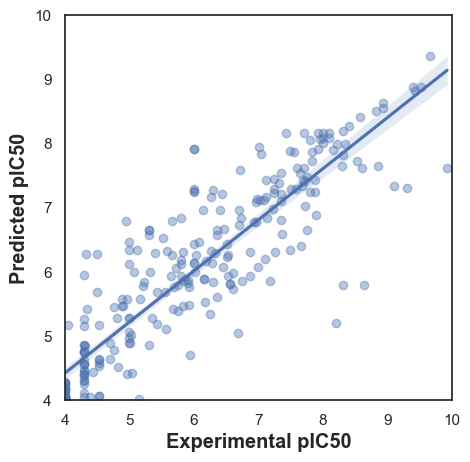

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x = Y_test,y = Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(4, 10)
ax.set_ylim(4, 10)
ax.figure.set_size_inches(5, 5)
plt.show